# diagnosis_regression.ipynb

This notebook uses de novo variant data from a large cohort of individuals with cardiac defects$^{1}$ to relate diagnosis categories to risk of having a de novo variant in a GATA4-TBX5 interactome gene.

$^{1}$Jin, Sheng Chih, Jason Homsy, Samir Zaidi, Qiongshi Lu, Sarah Morton, Steven R. DePalma, Xue Zeng, et al. 2017. “Contribution of Rare Inherited and de Novo Variants in 2,871 Congenital Heart Disease Probands.” Nature Genetics 49 (11): 1593–1601.

In [1]:
diagnoses = read.csv('../data/variants/diagnoses.csv', stringsAsFactors = FALSE)

categories = read.csv('../data/databases/diagnostic_categories.csv',header=TRUE, 
                      stringsAsFactors=FALSE)
categories = categories[,c(1:2)]
names(categories) = c("DIAGNOSES","CATEGORY")

In [2]:
head(diagnoses)

Blinded.ID,Cohort,Sample.Type,Cardiac.Category,Cardiac.Diagnoses,EM,NDD
950400255,PHN,Trio,LVO,"HLHS, Ventricular Septal Defect",No,Yes
1-00002,PCGC,Singleton,LVO,AORTIC STENOSIS | HYPOPLASTIC AORTIC ANNULUS | HYPOPLASTIC LEFT HEART SYNDROME | HYPOPLASTIC MITRAL VALVE | MITRAL STENOSIS | TUBULAR HYPOPLASIA OF AORTA + COARCTATION,Yes,No
1-00004,PCGC,Trio,CTD (TGA),"INVERTED CORONARIES WITH POSTERIOR LAD IN D-LOOP TGA | TRANSPOSITION D-LOOP WITH VENTRICULAR SEPTAL DEFECT | VENTRICULAR SEPTAL DEFECT, MUSCULAR",Yes,Unknown
1-00008,PCGC,Trio,LVO,"AORTIC STENOSIS - VALVAR | BICOMMISSURAL (BICUSPID, BILEAFLET, BIFOLIATE) AORTIC VALVE | LEFT AORTIC ARCH",No,No
1-00009,PCGC,Trio,CTD,"AORTIC VALVE POSITION RELATIVE TO THE PULMONARY VALVE, ANTERIOR | AORTIC VALVE POSITION RELATIVE TO THE PULMONARY VALVE, LEFT | PULMONARY ATRESIA,VALVAR | PULMONARY STENOSIS, LEFT | SDD | SINGLE OUTLET VENTRICULOARTERIAL CONNECTION | SINGLE VENTRICLE, LEFT; DOUBLE INLET LEFT VENTRICLE | UNIVENTRICULAR, DOUBLE INLET ATRIOVENTRICULAR CONNECTION",No,No
1-00018,PCGC,Trio,LVO,"AORTIC STENOSIS | BICOMMISSURAL (BICUSPID, BILEAFLET, BIFOLIATE) AORTIC VALVE | COARCTATION | HYPOPLASTIC AORTIC ANNULUS | HYPOPLASTIC LEFT VENTRICLE (SUBNORMAL CAVITY VOLUME) | MITRAL ATRESIA | TOTALLY ANOMALOUS PULMONARY VENOUS RETURN, SUPRACARDIAC | VENTRICULAR SEPTAL DEFECT",Yes,Yes


In [3]:
head(categories)

DIAGNOSES,CATEGORY
CHARGE SYNDROME,Syndromic
ELLIS VAN CREVELD SYNDROME,Syndromic
HOLT-ORAM SYNDROME,Syndromic
LOEYS DIETZ SYNDROME,Syndromic
KABUKI SYNDROME,Syndromic
NOONANS SYNDROME,Syndromic


In [4]:
# Match each proband to their individual diagnoses
diag_list = c()
diag_df = data.frame(matrix(ncol=2, nrow=0))
colnames(diag_df) = c("Blinded.ID", "DIAGNOSES")

for (i in 1:nrow(diagnoses)){
  
  my_diags = c()
  my_id = diagnoses[i,'Blinded.ID']
  
  if( diagnoses[i,'Cohort'] == "PCGC"){
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses']," \\| ")
    for(j in diags){
      diag_list = c(diag_list, trimws(j))
      my_diags = c(my_diags,trimws(j))
    }
  } else if(diagnoses[i,'Cohort'] == 'PHN' & grepl(';',diagnoses[i, 'Cardiac.Diagnoses'])){
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses'],";")
    for(j in diags){
      diag_list = c(diag_list, toupper(trimws(j)))
      my_diags = c(my_diags, toupper(trimws(j)))
    }
  } else{
    diags = strsplit(diagnoses[i,'Cardiac.Diagnoses'],", ")
    for(j in diags){
      diag_list = c(diag_list, toupper(trimws(j)))
      my_diags = c(my_diags, toupper(trimws(j)))
    }
  }
  
  df = data.frame(Blinded.ID = rep(my_id, length(my_diags)), DIAGNOSES = my_diags)
  diag_df = rbind(diag_df, df)
  
}

head(diag_df)

Blinded.ID,DIAGNOSES
950400255,HLHS
950400255,VENTRICULAR SEPTAL DEFECT
1-00002,AORTIC STENOSIS
1-00002,HYPOPLASTIC AORTIC ANNULUS
1-00002,HYPOPLASTIC LEFT HEART SYNDROME
1-00002,HYPOPLASTIC MITRAL VALVE


In [5]:
# Merge with refined categories
diag_df$Category = categories$CATEGORY[match(diag_df$DIAGNOSES, categories$DIAGNOSES)]
diag_df = diag_df[complete.cases(diag_df), ]
head(diag_df)

Blinded.ID,DIAGNOSES,Category
950400255,HLHS,Single Ventricle Defect
950400255,VENTRICULAR SEPTAL DEFECT,Septation
1-00002,AORTIC STENOSIS,Semilunar valvular
1-00002,HYPOPLASTIC AORTIC ANNULUS,Semilunar valvular
1-00002,HYPOPLASTIC LEFT HEART SYNDROME,Single Ventricle Defect
1-00002,HYPOPLASTIC MITRAL VALVE,AV valvular


In [6]:
# Find the number of de novo mutations each proband has in interactome genes
gene_table = read.table("../intermediate/interactome_lists/GATA4-TBX5_genes.txt", 
                        stringsAsFactors = FALSE)
interactome = gene_table$V1

dnv_cases = read.csv('../data/variants/DNV_cases.csv', stringsAsFactors = FALSE)
dnv_ctrls = read.csv('../data/variants/DNV_ctrls.csv', stringsAsFactors = FALSE)

dnv_cases = dnv_cases[which(dnv_cases$Variant.Class != 'syn'),]
dnv_ctrls = dnv_ctrls[which(dnv_ctrls$Variant.Class != 'syn'),]

dnv_cases$interactome <- ifelse(dnv_cases$Gene %in% interactome, 1, 0)
dnv_ctrls$interactome <- ifelse(dnv_ctrls$Gene %in% interactome, 1, 0)

case_var_count = aggregate(dnv_cases$interactome, by=list(Category=dnv_cases$Blinded.ID), 
                           FUN=sum)
ctrl_var_count = aggregate(dnv_ctrls$interactome, by=list(Category=dnv_ctrls$Blinded.ID), 
                           FUN=sum)

var_count = rbind(case_var_count, ctrl_var_count)
names(var_count) = c("Blinded.ID","interactome_dnv_count")
head(var_count)

Blinded.ID,interactome_dnv_count
1-00009,0
1-00018,0
1-00030,0
1-00045,0
1-00057,0
1-00058,0


In [7]:
# Append dummy variable columns based on diagnoses of each blinded ID
variable_list = unique(diag_df$Category)

variable_test = head(variable_list)
for(diagnosis in variable_list){
  var_count[,diagnosis] = 0
  
  focal_df = diag_df[which(diag_df$Category == diagnosis),]
  var_count[which(var_count$Blinded.ID %in% focal_df$Blinded.ID), diagnosis] <- 1
  
}

# Remove Syndromic and Arrythmia categories
var_count$`Arrhythmia/conduction defects` <- NULL
var_count$Syndromic <- NULL

head(var_count)

Blinded.ID,interactome_dnv_count,Single Ventricle Defect,Septation,Semilunar valvular,AV valvular,Arterial vascular anomaly,Coronary anomaly,Conotruncal (septation and spiraling),Situs (Van Praag/Anderson),Venous vascular anomaly,AV Canal,L/R Asymmetry,Misc,Cardiomyopathy
1-00009,0,1,0,1,0,0,0,1,1,0,0,0,0,0
1-00018,0,1,1,1,1,1,0,0,0,1,0,0,0,0
1-00030,0,1,1,1,1,1,0,0,0,0,0,0,0,0
1-00045,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1-00057,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1-00058,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [8]:
# Order as desired and fit to a poisson model

df = var_count[,c('Blinded.ID','interactome_dnv_count','Arterial vascular anomaly',
                  'Septation','Cardiomyopathy','AV Canal', 'Coronary anomaly',
                  'Conotruncal (septation and spiraling)','L/R Asymmetry',
                  'Venous vascular anomaly','Semilunar valvular','AV valvular',
                  'Single Ventricle Defect','Misc', 'Situs (Van Praag/Anderson)')]
X = df[2:ncol(df)]
row.names(X) = df$Blinded.ID
poisson.model <- glm(interactome_dnv_count~., data=X, family=poisson(link="log"))
summary(poisson.model)

result_df <- data.frame(summary(poisson.model)$coefficients)
result_df[which(result_df$Pr...z.. < 0.1),]


Call:
glm(formula = interactome_dnv_count ~ ., family = poisson(link = "log"), 
    data = X)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6246  -0.2864  -0.2249  -0.2161   3.6786  

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -3.75692    0.17412 -21.577  < 2e-16
`Arterial vascular anomaly`              0.66109    0.23919   2.764  0.00571
Septation                                0.44300    0.23312   1.900  0.05740
Cardiomyopathy                           0.68817    0.46879   1.468  0.14211
`AV Canal`                               0.51937    0.42925   1.210  0.22629
`Coronary anomaly`                       0.39837    0.43609   0.913  0.36098
`Conotruncal (septation and spiraling)`  0.12013    0.23713   0.507  0.61243
`L/R Asymmetry`                         -0.24270    0.62743  -0.387  0.69889
`Venous vascular anomaly`               -0.12823    0.36584  -0.351  0.72596
`Semil

,Estimate,Std..Error,z.value,Pr...z..
(Intercept),-3.7569184,0.1741151,-21.577215,2.940561e-103
`Arterial vascular anomaly`,0.6610940,0.2391856,2.763937,5.710859e-03
Septation,0.4429954,0.2331235,1.900261,5.739891e-02


In [9]:
# Install packages that give conda environments grief

if (! 'jtools' %in% installed.packages()[,'Package']){
    install.packages('jtools')
}

if (! 'ggstance' %in% installed.packages()[,'Package']){
    install.packages('ggstance')
}

In [10]:
# Visualization
library(jtools)
library(ggplot2)
pdf("../manuscript/figures/diagnostic_category_regression_lenient-septation.pdf")
p <- plot_summs(poisson.model, scale = TRUE, exp=TRUE)
p + labs(x="Relative Risk (95% Confidence)")

dev.off()

Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools
Loading required namespace: broom.mixed


png 
  2

Loading required namespace: broom.mixed


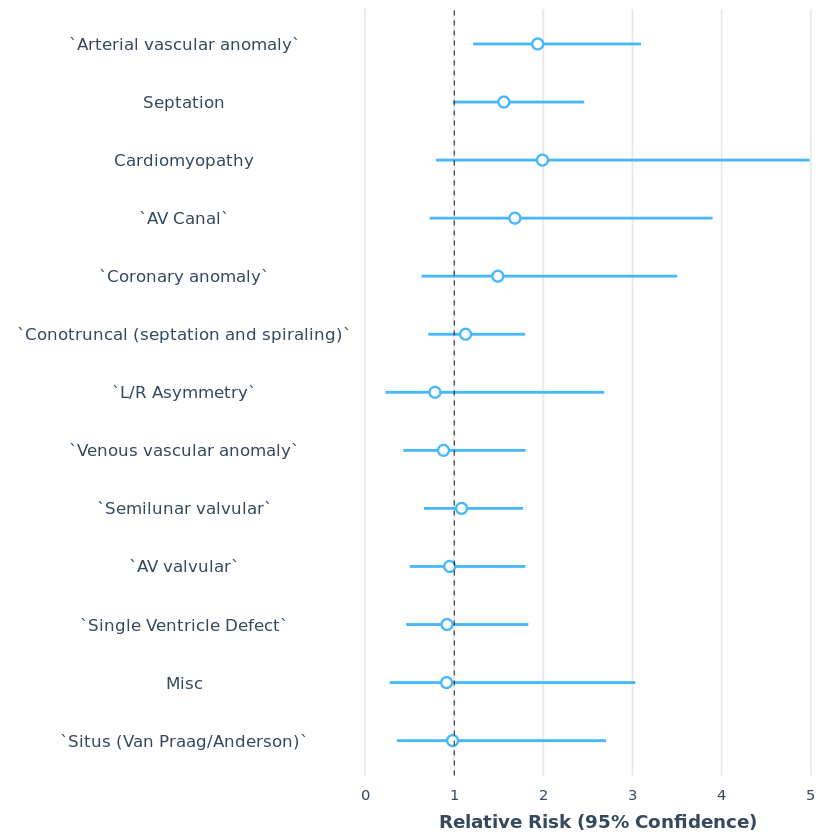

In [11]:
p <- plot_summs(poisson.model, scale = TRUE, exp=TRUE)
p + labs(x="Relative Risk (95% Confidence)")

### Save out data: how many probands per diagnosis? How many interactome mutations?

In [12]:
n_probands = colSums(var_count[,c(3:ncol(var_count))])
n_probands

Single Ventricle Defect                             Septation 
                                  358                                   826 
                   Semilunar valvular                           AV valvular 
                                  720                                   416 
            Arterial vascular anomaly                      Coronary anomaly 
                                  488                                    98 
Conotruncal (septation and spiraling)            Situs (Van Praag/Anderson) 
                                  788                                   109 
              Venous vascular anomaly                              AV Canal 
                                  254                                   110 
                        L/R Asymmetry                                  Misc 
                                   94                                    71 
                       Cardiomyopathy 
                                   54

In [13]:
get_n_mutations <- function(diagnosis, vdf){
    
    dat = vdf[which(vdf[,diagnosis]==1),]
    count = sum(dat$interactome_dnv_count)
    
    return(count)
}

In [14]:
result_df$Number.of.Probands = 'NA'
result_df$Total.Interactome.Mutations = 'NA'

for (i in c(2:nrow(result_df))){
    diagnosis = gsub('`','',row.names(result_df)[i])
    result_df[i,'Number.of.Probands'] = n_probands[diagnosis]
    result_df[i,'Total.Interactome.Mutations'] = get_n_mutations(diagnosis,var_count)
}
result_df

,Estimate,Std..Error,z.value,Pr...z..,Number.of.Probands,Total.Interactome.Mutations
(Intercept),-3.75691843,0.1741151,-21.5772148,2.940561e-103,NA,NA
`Arterial vascular anomaly`,0.66109398,0.2391856,2.7639369,5.710859e-03,488,33
Septation,0.44299543,0.2331235,1.9002607,5.739891e-02,826,45
Cardiomyopathy,0.68816932,0.4687896,1.4679705,1.421122e-01,54,5
`AV Canal`,0.51937301,0.4292456,1.2099670,2.262916e-01,110,7
`Coronary anomaly`,0.39836789,0.4360905,0.9134981,3.609806e-01,98,6
`Conotruncal (septation and spiraling)`,0.12013231,0.2371294,0.5066107,6.124280e-01,788,37
`L/R Asymmetry`,-0.24270215,0.6274317,-0.3868184,6.988906e-01,94,4
`Venous vascular anomaly`,-0.12822982,0.3658403,-0.3505077,7.259577e-01,254,11
`Semilunar valvular`,0.07969122,0.2511525,0.3173021,7.510143e-01,720,35


In [15]:
result_df$Relative.Risk = exp(result_df$Estimate)
result_df

,Estimate,Std..Error,z.value,Pr...z..,Number.of.Probands,Total.Interactome.Mutations,Relative.Risk
(Intercept),-3.75691843,0.1741151,-21.5772148,2.940561e-103,NA,NA,0.0233556
`Arterial vascular anomaly`,0.66109398,0.2391856,2.7639369,5.710859e-03,488,33,1.9369101
Septation,0.44299543,0.2331235,1.9002607,5.739891e-02,826,45,1.5573652
Cardiomyopathy,0.68816932,0.4687896,1.4679705,1.421122e-01,54,5,1.9900690
`AV Canal`,0.51937301,0.4292456,1.2099670,2.262916e-01,110,7,1.6809734
`Coronary anomaly`,0.39836789,0.4360905,0.9134981,3.609806e-01,98,6,1.4893919
`Conotruncal (septation and spiraling)`,0.12013231,0.2371294,0.5066107,6.124280e-01,788,37,1.1276460
`L/R Asymmetry`,-0.24270215,0.6274317,-0.3868184,6.988906e-01,94,4,0.7845051
`Venous vascular anomaly`,-0.12822982,0.3658403,-0.3505077,7.259577e-01,254,11,0.8796512
`Semilunar valvular`,0.07969122,0.2511525,0.3173021,7.510143e-01,720,35,1.0829526


In [16]:
names(result_df) <- c('Regression.Coefficient', 'Std.Error','z.score','p.value',
                      'N.probands.with.diagnosis','N.interactome.mutations.in.probands',
                      'Relative.Risk')
row.names(result_df) <- gsub('`','',row.names(result_df))

In [17]:
result_df = result_df[,c('Regression.Coefficient','Relative.Risk','Std.Error','z.score',
                         'p.value','N.probands.with.diagnosis',
                         'N.interactome.mutations.in.probands')]

write.csv(result_df, '../manuscript/tables/diagnostic_regression.csv', 
          quote=FALSE)